# Task: Classification task with NN

The goal of the task is to build a coin classifier using a neural network. In this notebook I will demonstrate progressive resizing to achieve the most accurate possible results. My goal for this models accuracy was 97% as the owner of the dataset had a model that achieved 96% accuracy.

As one quick note: I'm using Luis Moneda's original dataset, instead of VolodymyrGavrysh's copy (which is the dataset that has the task attached to it). For whatever reason I had greater difficulty getting the classifier to run well on the other dataset (my final accuracy was around 93% and this model did better), it might not be that I wasn't using the best method to untar the .jpg files.

Thanks to:
* Luis Moneda for the dataset https://www.kaggle.com/lgmoneda/br-coins
* VolodymyrGavrysh for the task https://www.kaggle.com/volodymyrgavrysh/brazilian-coins-dataset-classification25k-images/tasks?taskId=395

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/__notebook__.ipynb


In [2]:
from fastai import *
from fastai.vision import *

torch.Size([480, 640])


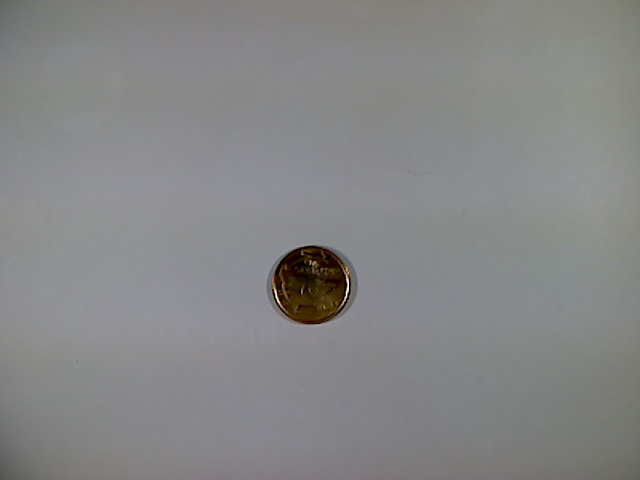

In [3]:
img = open_image(Path('/kaggle/input/br-coins/classification_dataset/all/25_1477287102.jpg'))
print(img.size)
img

In [4]:
train_path = Path('/kaggle/input/br-coins/classification_dataset/all/')
fnames = get_image_files(train_path)
pat = r'/([^/]+)_\d+.jpg$'

In [5]:
data = ImageDataBunch.from_name_re(train_path,
                                   fnames,
                                   pat,
                                   ds_tfms=get_transforms(flip_vert=True, max_zoom=1.0,max_rotate=25, max_lighting=0.1, max_warp=0.1, p_affine=0.75, p_lighting=0.75),# A small portion of the images have the coin near the corner of the image so zooming in can remove alot of signal
                                   size=64,#224,#480
                                   bs=64
                                  ).normalize(imagenet_stats)

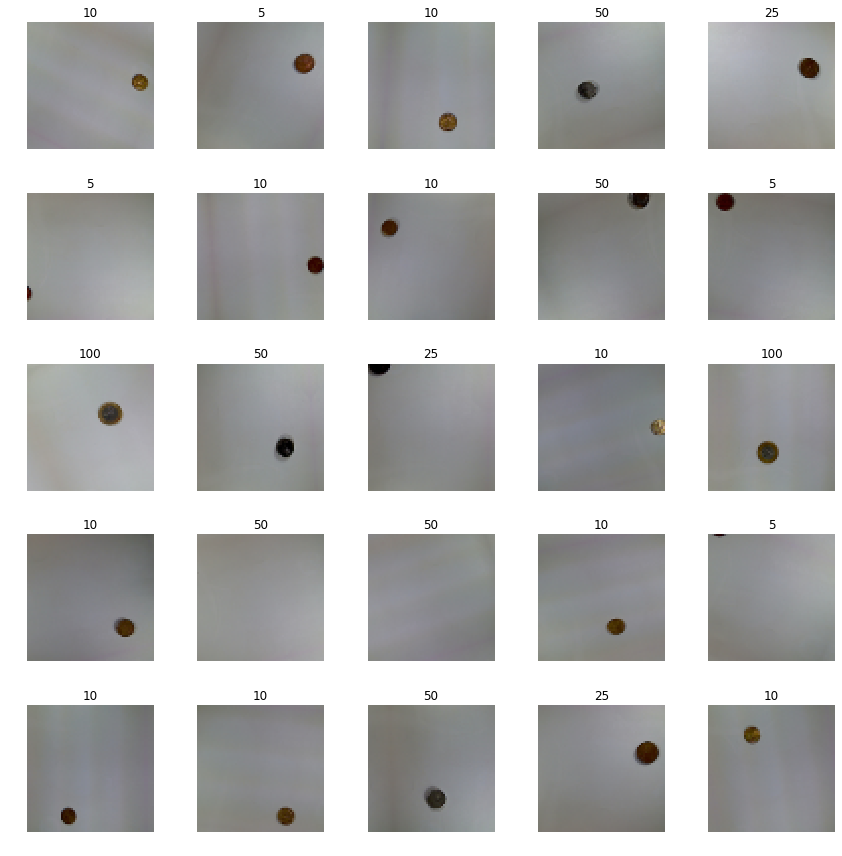

In [6]:
data.show_batch(row=3, figsize=(12,12))

# Quirk

For some silly reason if I run the cnn_learner with pretrained left in its default True state then I can't commit this notebook successfully. But if I train the model in one of these kernels, download it, then upload it to the notebook and then load it the notebook, then the notebook commits just fine. The code below generates the model that I will be updating in this notebook.

`
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(8)
Model_Path = Path('/kaggle/working/')
learn.model_dir = Model_Path
learn.save('stage-1')
`

In [7]:
learn = cnn_learner(data, models.resnet34, pretrained=False, metrics=error_rate)

In [8]:
Model_Path = Path('/kaggle/input/brazillian-coin-fastai-classifier/')
learn.model_dir = Model_Path
learn.load('stage-1');

In [9]:
learn.load('stage-1')
learn.unfreeze()

In [10]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.814981,0.687881,0.229133,00:32
1,0.692013,0.432001,0.150573,00:29


In [11]:
Model_Path = Path('/kaggle/working')
learn.model_dir = Model_Path
learn.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


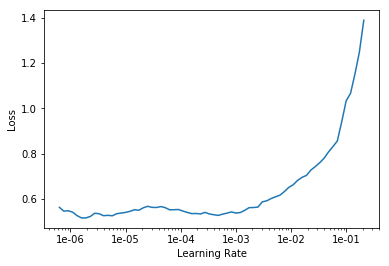

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.unfreeze()

In [14]:
#looking at the curve, we don't have much we can use for a learning rate
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.546505,0.400778,0.135843,00:29
1,0.494919,0.396583,0.129296,00:28


In [15]:
learn.save('stage-3')

# Second Verse same as the first!

For the first phase, we reached an accuracy of about 85%, but not to the goal yet, the images for this training set are less than a quarter of their original size. Now the model will be trained again, this time on the images that are about half size of the original images.

In [16]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [17]:
data = ImageDataBunch.from_name_re(train_path,
                                   fnames,
                                   pat,
                                   ds_tfms=get_transforms(flip_vert=True, max_zoom=1.0,max_rotate=25, max_lighting=0.1, max_warp=0.1, p_affine=0.75, p_lighting=0.75),
                                   size=224,
                                   bs=64,
                                  ).normalize(imagenet_stats)

In [18]:
learn = cnn_learner(data, models.resnet34, pretrained=False, metrics=error_rate)

In [19]:
Model_Path = Path('/kaggle/working')
learn.model_dir = Model_Path
learn.load('stage-3');

In [20]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.676984,0.885543,0.255319,01:15
1,0.481338,0.256621,0.109656,01:15


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


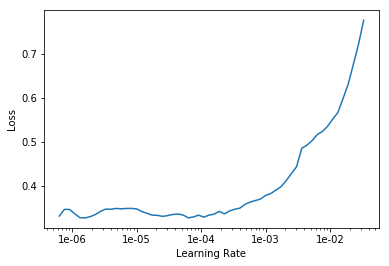

In [21]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(5, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.338719,0.235637,0.099836,01:14
1,0.347201,0.220983,0.090016,01:14
2,0.328188,0.224000,0.086743,01:16
3,0.317230,0.217522,0.083470,01:14
4,0.303112,0.215383,0.086743,01:14


In [23]:
learn.save('stage-4')

# Once more with feeling!

Notice that with just this step the error rate of the model is already well under 10%. Now to train the model on the images that are full size to create the final model

In [24]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [25]:
data = ImageDataBunch.from_name_re(train_path,
                                   fnames,
                                   pat,
                                   ds_tfms=get_transforms(flip_vert=True, max_zoom=1.0,max_rotate=25, max_lighting=0.1, max_warp=0.1, p_affine=0.75, p_lighting=0.75),
                                   size=480,
                                   bs=64
                                  ).normalize(imagenet_stats)

In [26]:
learn = cnn_learner(data, models.resnet34, pretrained=False, metrics=error_rate)
Model_Path = Path('/kaggle/working')
learn.model_dir = Model_Path
learn.load('stage-4');

In [27]:
learn.fit_one_cycle(6, 1e-4)#

epoch,train_loss,valid_loss,error_rate,time
0,0.564206,0.318155,0.124386,01:49
1,0.385774,0.205979,0.068740,01:49
2,0.323837,0.165680,0.054010,01:50
3,0.294322,0.164249,0.058920,01:48
4,0.259627,0.119542,0.037643,01:46
5,0.245408,0.116567,0.031097,01:46


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


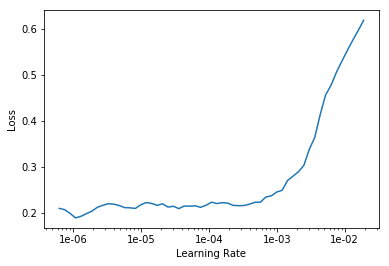

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
learn.save('stage-5')

In [30]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.215955,0.113561,0.032733,01:49


In [31]:
learn.save('final')

# Final Thoughts:

The model didn't exactly hit my goal. Managed to get about a 96% accuracy, which isn't bad, but not ahead of similiar models.

I did not expect to get so small a boost in performance when I finally used the almost full sized images. This is my first attempt at progressive resizing so I am still experimenting.

There is also one major flaw with this model, because I recreated the dataset for each iteration (twice for the images shrunk down to 64 by 64, once for the images at 224 by 224, and a fourth time with the images at size 480 by 480), each time I recreated the dataset the validation and training data was reshuffled. This means that the model is being tested on data that was likely already labeled for it in a previous iteration. The way around this would be to create a training and validation folder and feed those to the databunch object (I ran a little tight on time with this one so I didn't get around to that).

This year I've challenged myself to complete one task on Kaggle per week, in order to develop a larger Data Science portfolio. If you found this notebook useful or interesting please give it an upvote. I'm always open to constructive feedback. If you have any questions, comments, concerns, or if you would like to collaborate on a future task of the week feel free to leave a comment here or message me directly.